In [1]:
# IMPORTS
import copy
import glob
from imdb import IMDb
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nltk
import numpy as np
import random
import statistics
import subprocess
import textclean
import unicodedata

from __future__ import print_function
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from nltk.stem import PorterStemmer
from scipy.stats import binom
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import AffinityPropagation
from textclean import textclean
from nltk.tokenize import TweetTokenizer

nltk.download('punkt')

# CONSTANTS
NUM_FOLDS = 10
ACL_PATH = "aclImdb_v1/aclImdb/{}/*"
ACL_FOLDER_PATHS = [ACL_PATH.format("train/unsup"),
                    ACL_PATH.format("train/pos"),
                    ACL_PATH.format("train/neg"),
                    ACL_PATH.format("test/pos"),
                    ACL_PATH.format("test/neg")]
PANG_POS_PATH = "POS-tokenized/POS/*"
PANG_NEG_PATH = "NEG-tokenized/NEG/*"
SEED = 0
NUM_FOLDS = 10
POS = 1
NEG = -1
R = 5000

[nltk_data] Downloading package punkt to /home/karen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Functions

### Fetch Data

In [3]:
# IMPORTS
import copy
import glob
from imdb import IMDb
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nltk
import numpy as np
import random
import statistics
import subprocess
import textclean
import unicodedata

from __future__ import print_function
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from nltk.stem import PorterStemmer
from scipy.stats import binom
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import AffinityPropagation
from textclean import textclean
from nltk.tokenize import TweetTokenizer

nltk.download('punkt')

# CONSTANTS
NUM_FOLDS = 10
ACL_PATH = "aclImdb_v1/aclImdb/{}/*"
ACL_FOLDER_PATHS = [ACL_PATH.format("train/unsup"),
                    ACL_PATH.format("train/pos"),
                    ACL_PATH.format("train/neg"),
                    ACL_PATH.format("test/pos"),
                    ACL_PATH.format("test/neg")]
PANG_POS_PATH = "POS-tokenized/POS/*"
PANG_NEG_PATH = "NEG-tokenized/NEG/*"
SEED = 0
NUM_FOLDS = 10
POS = 1
NEG = -1
R = 5000

In [42]:
def write_embeddings_training_set_pos_tag(folder_paths_list):
    """Finds tags for each word in doc. Writes to disk. Returns it."""
    all_docs = []
    for folder_path in folder_paths_list:
        folder_documents = _write_pos_tag_for_folder(folder_path)
        all_docs.extend(folder_documents)
        return all_docs

def _write_pos_tag_for_folder(folder_path):
    files = glob.glob(folder_path)
    folder_documents = []
    tknzr = TweetTokenizer()
    for file_name in files: 
        with open(file_name) as fp:
            with open("tagged/{}_tagged.txt".format(
                file_name.split(".")[0]), "w+") as tag_fp:
                document = fp.read()
                doc_words = filter(None, tknzr.tokenize(document))
                tagged_doc_list = nltk.pos_tag(doc_words)
                to_print = "\n".join(["{}zzzz{}".format(word.encode('utf-8'), word_type.encode('utf-8'))
                            for (word,word_type) in tagged_doc_list])
                tag_fp.write(to_print)
                folder_documents.append(doc_words)
    return folder_documents

In [22]:
def get_pang_dataset(pos_path, neg_path):
    pos_data = _get_docs_from_folder(pos_path, pretokenised=True)
    neg_data = _get_docs_from_folder(neg_path, pretokenised=True)
    
    validation_set = []
    test_and_training_docs = []
    for i, pos_and_neg_doc in enumerate(zip(pos_data, neg_data)):
        pos_doc, neg_doc = pos_and_neg_doc
        
        # Obtain validation set.
        if i%10 == 0:
            validation_set.append((pos_doc, POS))
            validation_set.append((neg_doc, NEG))
        else:
            test_and_training_docs.append((pos_doc, neg_doc))
        
    # Split remaining data into folds.
    data_set = {}
    for fold_index in range(NUM_FOLDS):
        data_set[fold_index] = []
    for i, (pos_doc, neg_doc) in enumerate(test_and_training_docs):
        data_set[i%NUM_FOLDS].append((pos_doc, POS))
        data_set[i%NUM_FOLDS].append((neg_doc, NEG))
    return validation_set, data_set

In [23]:
def apply_bigrams_and_presence(pang_folds):
    pang_folds_bigrams_presence = dict()
    for key, fold in pang_folds.items():
        pang_folds_bigrams_presence[key] = []
        for word_list, sentiment in fold:
            unique_bigrams = list(set(_unigrams_to_bigrams(word_list)))
            pang_folds_bigrams_presence[key].append((unique_bigrams, sentiment))
    return pang_folds_bigrams_presence

def _unigrams_to_bigrams(doc):
    return [word1 + word2 for word1, word2 
            in zip(doc[:-1], doc[1:])]

### Doc2Vec Classification

In [24]:
# def train_doc2vec_model(training_set, epochs=10, dm=0, window=1, feature_size=100, hs=0):
#     documents = [TaggedDocument(doc, [i]) 
#                  for i, doc in enumerate(training_set)]
#     model = Doc2Vec(documents, seed=SEED, dbow_words=1, 
#                     epochs=epochs, workers=4, dm=dm, window=window, feature_size=feature_size, hs=hs)
#     return model

In [25]:
def run_svm(training_set, test_set, doc2vec_model=None):
    training_file_name = "training_embeddings.txt"
    test_file_name = "test_embeddings.txt"
    model_file_name = "model_file.txt"
    predictions_file_name = "predictions.txt"
    
    if (doc2vec_model == None):
        # If no doc2vec model is given, use BoW implementation.
        word_encodings = dict()
        _store_docs_as_BOW_counts(training_set, word_encodings,
                                  training_file_name)
        _store_docs_as_BOW_counts(test_set, word_encodings,
                                  test_file_name)
    else:
        _store_docs_as_embeddings(training_set, doc2vec_model,
                                 training_file_name)
        _store_docs_as_embeddings(test_set, doc2vec_model, 
                                 test_file_name)
    # TRAIN
    subprocess.call(["svm_light/svm_learn", 
                     training_file_name, 
                     model_file_name])
    
    # CLASSIFY
    subprocess.call(["svm_light/svm_classify",
                     test_file_name,
                     model_file_name,
                     predictions_file_name])
    
    # TEST
    classifications = []
    marked_results = []
    true_sentiments = []
    with open(predictions_file_name) as pred_fp:
        for test_doc in test_set:
            doc_words, doc_sentiment = test_doc
            result = float(pred_fp.readline())
            classification = np.sign(result)
            classifications.append(classification)
            true_sentiments.append(doc_sentiment)
            if classification == doc_sentiment:
                marked_results.append(1)
            else:
                marked_results.append(0)
    return marked_results, classifications, true_sentiments

In [26]:
def _store_docs_as_embeddings(data_set, doc2vec_model, name_of_file):
    with open(name_of_file, "w+") as fp:
        for document in data_set:
            doc_words, sentiment = document
            feature_vector = doc2vec_model.infer_vector(doc_words)
            feature_values = ["{}:{}".format(index + 1, value)
                              for index, value 
                              in enumerate(feature_vector)]
            line = "{} {}\n".format(sentiment, 
                                  " ".join(feature_values))
            fp.write(line)
            
def _store_docs_as_BOW_counts(data_set, word_encodings, name_of_file):
    with open(name_of_file, "w+") as fp:
        new_word_count = len(word_encodings) +1
        for doc_words, sentiment in data_set:
            word_counts = dict()
            for word in doc_words:
                if word not in word_encodings:
                    word_encodings[word] = new_word_count
                    new_word_count += 1
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] = word_counts[word] + 1
            feature_values = [(word_encodings[word], count)
                              for (word, count) 
                              in word_counts.items()]
            feature_values.sort()
            feature_values = ["{}:{}".format(encoding, count) 
                              for (encoding, count) 
                              in feature_values]
            feature_values = " ".join(feature_values)
            line = "{} {}\n".format(sentiment, feature_values)
            fp.write(line)

### Finetuning Hyperparameters

In [27]:
def grid_search(embeddings_training_set, 
                svm_training_set, svm_test_set,
                dm_list=[], window_list=[], epochs_list=[], 
                feature_size_list=[], hs_list=[], negative_list=[],
                min_count_list=[]):
    """Train Doc2Vec on a bunch of parameters and test SVM on this.
    
    Each input is a list, defining the parameter to test.
    Results are stored in a file.
    
    dbow: 1 got distributes memory. Otherwise for dbow. 
    window: The maximum distance between the current and 
    predicted word within a sentence.
    epochs: number of iterations.
    """
    with open("results4.txt", "w+") as fp:
        for min_count in min_count_list:
            for hs in hs_list:
                for dm in dm_list:
                    for window in window_list:
                        for epochs in epochs_list:
                            for feature_size in feature_size_list: 
                                for negative in negative_list:
                                    params_string = "min_count={}; hs={}; dm={}; window={}; epochs={}; feature_size={}; negative={}\n".format(
                                        min_count, hs, dm, window, epochs, feature_size, negative)
                                    fp.write(params_string)
                                    print(params_string)
                                    documents = [TaggedDocument(doc, [i]) 
                                                 for i, doc in enumerate(embeddings_training_set)]
                                    doc2vec_model = Doc2Vec(documents, seed=SEED, dbow_words=1, 
                                                            epochs=epochs, workers=4, dm=dm, window=window, 
                                                            feature_size=feature_size, hs=hs,
                                                            negative=negative, min_count=min_count)
                                    results = run_svm(svm_training_set, 
                                                      svm_test_set, 
                                                      doc2vec_model)
                                    results_string = map(str, results)
                                    results_string = " ".join(results_string)
                                    results_string = "{}\n".format(results_string)
                                    fp.write(results_string)
                                    print(results_string)
                                    accuracy_string = "Accuracy is: {}\n\n".format(accuracy(results))
                                    fp.write(accuracy_string)
                                    print(accuracy_string)

def do_a_grid_search(pang_folds):
    finetuning_training_set = [doc for fold in pang_folds.values()
                               for doc in fold]
    grid_search(embeddings_training_set, 
                finetuning_training_set, validation_set,
                hs_list=[0], dm_list=[0,1], window_list=[5, 10, 15], 
                epochs_list=[15], feature_size_list=[100], negative_list=[4,5,6], min_count_list=[10])

### Testing

In [28]:
def permutation_test(baseline_results, system_results, 
                     subset_count=R):
    """Runs the permutation test on two sets of results.
    
    Args:
        baseline_results: The classification results for the 
            baseline.
        system_results: The classification results for the new 
            system. The files should be in the same order as
            in baseline_results.
        epochs: number of iterations.
    
    Returns:
        p-value.
    """
    if len(baseline_results) != len(system_results):
        print("Need equal number of results for perm test!")
        return
    
    # Get mean difference of true results.
    base_mean_diff = _mean_difference(
        baseline_results, system_results)
    
    # Do R sets of permutations
    exceeded_base_count = 0
    for _ in range(subset_count):
        # Apply flips randomly
        baseline_modified = []
        system_modified = []
        for base_val, system_val in zip(baseline_results, 
                                        system_results):
            flip = random.choice([True, False])
            if flip:
                baseline_modified.append(system_val)
                system_modified.append(base_val)
            else:
                baseline_modified.append(base_val)
                system_modified.append(system_val)
        
        # Calculate difference in mean
        new_mean_diff = _mean_difference(baseline_modified, 
                                         system_modified)
        
        if new_mean_diff >= base_mean_diff:
            exceeded_base_count += 1
    
    # Return probability.
    return (exceeded_base_count + 1)/float(subset_count + 1)
        
def _mean_difference(results_1, results_2):
    return abs(statistics.mean(results_1) - statistics.mean(results_2))

In [29]:
def accuracy(results):
    return statistics.mean(results) * 100

In [30]:
def cross_validate_svm(pang_folds, doc2vec_model=None):
    all_results = []
    all_classifications = []
    true_sentiments = []
    for fold_num in pang_folds.keys():
        test_set = pang_folds[fold_num]
        training_set = [document 
                        for (index, fold) in pang_folds.items()
                        for document in fold
                        if index != fold_num]
        fold_results, fold_classifications, fold_true_sentiments = run_svm(training_set, test_set, 
                               doc2vec_model=doc2vec_model)
        all_results.append(fold_results)
        all_classifications.append(fold_classifications)
        true_sentiments.append(fold_true_sentiments)
    return all_results, all_classifications, true_sentiments
       
def cross_validate_data_set(data_set):
    """ Yields data set organised into training and test sets.
    
    Args:
        data_set: a dict mapping fold number to fold data.
        
    Returns: 
        A tuple (training_set, test_set). Each of these entries
        represents a list of docs (a list of list of strings).
    """
    for test_num in data_set.keys():
        training_set = []
        test_set = []
        for fold_num, curr_fold in data_set.items():
            if fold_num == test_num:
                test_set = curr_fold
            else:
                training_set.extend(curr_fold)
        yield (training_set, test_set)

### Visualisation

In [31]:
def reduce_dimensions(data, dimensions):
    return TSNE(n_components=dimensions).fit_transform(data)

In [32]:
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [33]:
def create_2d_plot(vectors, labels):
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [vector[0] for vector in vectors]
    ys = [vector[1] for vector in vectors]
    ax.scatter(xs, ys)
    for x, y, label in zip(xs, ys, labels):
        ax.annotate(label, (x, y))
    plt.show()

### Analysis

In [34]:
def find_most_common_words(document_list, num_words, 
                           word_type=None):
    """
    Args:
        document_list: A list of (id, [word, list,..]) pairs
    """
    
    
    # Apply part of speech tag filter
#     document_list = [_remove_empty_strings(document)
#                      for fold_documents in pang_folds.values()
#                      for (document, _) in fold_documents]
    if word_type == None:
        word_list = [word 
                     for document in document_list
                     for word in document]
    else:
        tagged_doc_list = [nltk.pos_tag(document)
                           for (_, document) in document_list]
        word_list = [word
                     for document in tagged_doc_list
                     for (word, tag) in document
                     if tag.startswith(word_type)]

    # Count words
    word_counts = dict()
    for word in word_list:
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] = word_counts[word] + 1
    
    # Extract X most common
    word_count_list = [(count, word) 
                       for word, count 
                       in word_counts.items()]
    word_count_list.sort(reverse=True)
    most_common_words = word_count_list[:num_words]
    
    return [word for (_, word) in most_common_words]

def _remove_empty_strings(words_list):
    return [word for word in words_list if word]

In [35]:
def plot_most_common_words(document_list, num_words, 
                           word_type=None):    
    # Get common words
    print("Getting most common words...")
    most_common_words = find_most_common_words(
        document_list, num_words, word_type)
    word_vectors = [doc2vec_model.wv.get_vector(word)
                    for word in most_common_words]
    reduced_vectors = reduce_dimensions(word_vectors, 2)
    
    print("Plotting words...")
    # Plot word vectors
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [vector[0] for vector in reduced_vectors]
    ys = [vector[1] for vector in reduced_vectors]
    ax.scatter(xs, ys)
    for x, y, label in zip(xs, ys, most_common_words):
        ax.annotate(label, (x, y))
    plt.show()

In [37]:
def plot_words_in_document(document, doc2vec_model):
    doc_vector = doc2vec_model.infer_vector(document)

    words = []
    word_vectors = []
    for word in set(document):
        try:
            vector = doc2vec_model.wv.get_vector(word)
            words.append(word)
            word_vectors.append(vector)
            #print("{}: {}".format(word, vector))
        except:
            pass
    
    words.append("DOCUMENT")
    word_vectors.append(doc_vector)

    reduced_vectors = reduce_dimensions(word_vectors, 3)
    create_2d_plot(reduced_vectors, words)
    
# plot_words_in_document(["hello", "there", "friend"])

# Executing Code

### Train Models

In [38]:
# GET DATA SETS
print("Loading ACL training set...")
embeddings_training_set = get_embeddings_training_set(
    ACL_FOLDER_PATHS)
print("Fetched {} docs.".format(len(embeddings_training_set)))

print("Loading Pang validation set...")
validation_set, pang_folds = get_pang_dataset(
    PANG_POS_PATH, PANG_NEG_PATH)
print("Fetched {} validation docs and ".format(len(validation_set)))
print("{} folds with {} docs each.".format(len(pang_folds), 
                                            len(pang_folds[0])))

Loading ACL training set...
Fetched 100000 docs.
Loading Pang validation set...
Fetched 200 validation docs and 
10 folds with 180 docs each.


In [43]:
# labelled_docs = write_embeddings_training_set_pos_tag(ACL_FOLDER_PATHS)
labelled_folder_paths = ["tagged/{}".format(folder)
                         for folder in ACL_FOLDER_PATHS]
labelled_embeddings_training = get_embeddings_training_set(labelled_folder_paths)

In [47]:
embeddings_training_set[0]

[u'This',
 u'Would',
 u'make',
 u'a',
 u'excellent',
 u'remake',
 u',',
 u'just',
 u'a',
 u'remarkable',
 u'story',
 u'.',
 u'The',
 u'acting',
 u'is',
 u'wonderful',
 u'as',
 u'well',
 u'as',
 u'the',
 u'direction',
 u'.',
 u'I',
 u'first',
 u'saw',
 u'this',
 u'episode',
 u'in',
 u'1995',
 u',',
 u'and',
 u'it',
 u'has',
 u'haunted',
 u'me',
 u'ever',
 u'since',
 u'.',
 u'It',
 u'has',
 u'created',
 u'a',
 u'fascination',
 u'with',
 u'ww1',
 u'and',
 u'I',
 u'now',
 u'collect',
 u'ww1',
 u'artifacts',
 u'.',
 u'This',
 u'story',
 u'could',
 u'easily',
 u'be',
 u'adapted',
 u'in',
 u'to',
 u'a',
 u'feature',
 u'film',
 u'or',
 u'even',
 u'a',
 u'mini',
 u'serious',
 u'.',
 u'It',
 u'states',
 u'at',
 u'the',
 u'end',
 u'of',
 u'the',
 u'story',
 u'that',
 u'it',
 u'is',
 u'based',
 u'on',
 u'actual',
 u'events',
 u'.',
 u'Its',
 u'hard',
 u'to',
 u'believe',
 u'that',
 u'it',
 u'has',
 u'never',
 u'been',
 u'mentioned',
 u'since',
 u'.',
 u'I',
 u'am',
 u'currently',
 u'working',
 u'o

In [48]:
# # TRAIN DOC2VEC MODEL
print("Training Doc2Vec model...")
doc2vec_docs = [TaggedDocument(doc, [i]) 
                 for i, doc in enumerate(embeddings_training_set)]
doc2vec_model = Doc2Vec(doc2vec_docs, seed=SEED, dbow_words=1, 
                epochs=15, workers=4, dm=0, window=10,
                feature_size=100, hs=0, min_count=5, negative=4)
doc2_vec_file = get_tmpfile("my_doc2vec_model")

doc2vec_model.save(doc2_vec_file)
modoc2vec_modeldel = Doc2Vec.load(doc2_vec_file)
print(doc2vec_model)

Training Doc2Vec model...
Doc2Vec(dbow+w,d100,n4,w10,mc5,s0.001,t4)


In [45]:
doc2_vec_model = Doc2Vec.load(doc2_vec_file)

NameError: name 'doc2_vec_file' is not defined

In [ ]:
# RUN SVM WITH BOW IMPL
bow_results, bow_classifications, bow_true = cross_validate_svm(pang_folds)
for i, result in enumerate(bow_results):
    print("Test {}: {}".format(i, accuracy(result)))
print("Average accuracy = {}\n".format(accuracy(flatten(bow_results))))

# RUN SVM WITH BOW OPTIMAL
modified_pang_folds = apply_bigrams_and_presence(pang_folds)
bow_results_modified, bow_mod_classifications, bow_mod_true = cross_validate_svm(modified_pang_folds)
for i, result in enumerate(bow_results_modified):
    print("Test {}: {}".format(i, accuracy(result)))
print("Average accuracy = {}\n".format(accuracy(flatten(bow_results_modified))))


# RUN SVM WITH DOC2VEC
doc2vec_results, doc2vec_classifications, doc2vec_true = cross_validate_svm(pang_folds, doc2vec_model)
for i, result in enumerate(doc2vec_results):
    print("Test {}: {}".format(i, accuracy(result)))
print("Average accuracy = {}".format(accuracy(flatten(doc2vec_results))))

In [1]:
## p1 = permutation_test(flatten(bow_classifications), flatten(doc2vec_classifications))
print(p1)

p2 = permutation_test(flatten(bow_mod_classifications), flatten(doc2vec_classifications))
print(p2)

p3 = permutation_test(flatten(bow_classifications), flatten(bow_mod_classifications))
print(p3)

NameError: name 'p1' is not defined

### Visualise Embeddings

In [141]:
reduced_vectors = reduce_dimensions(doc2vec_model.wv.vectors[:200], 3)
reduced_vectors = normalize(reduced_vectors)

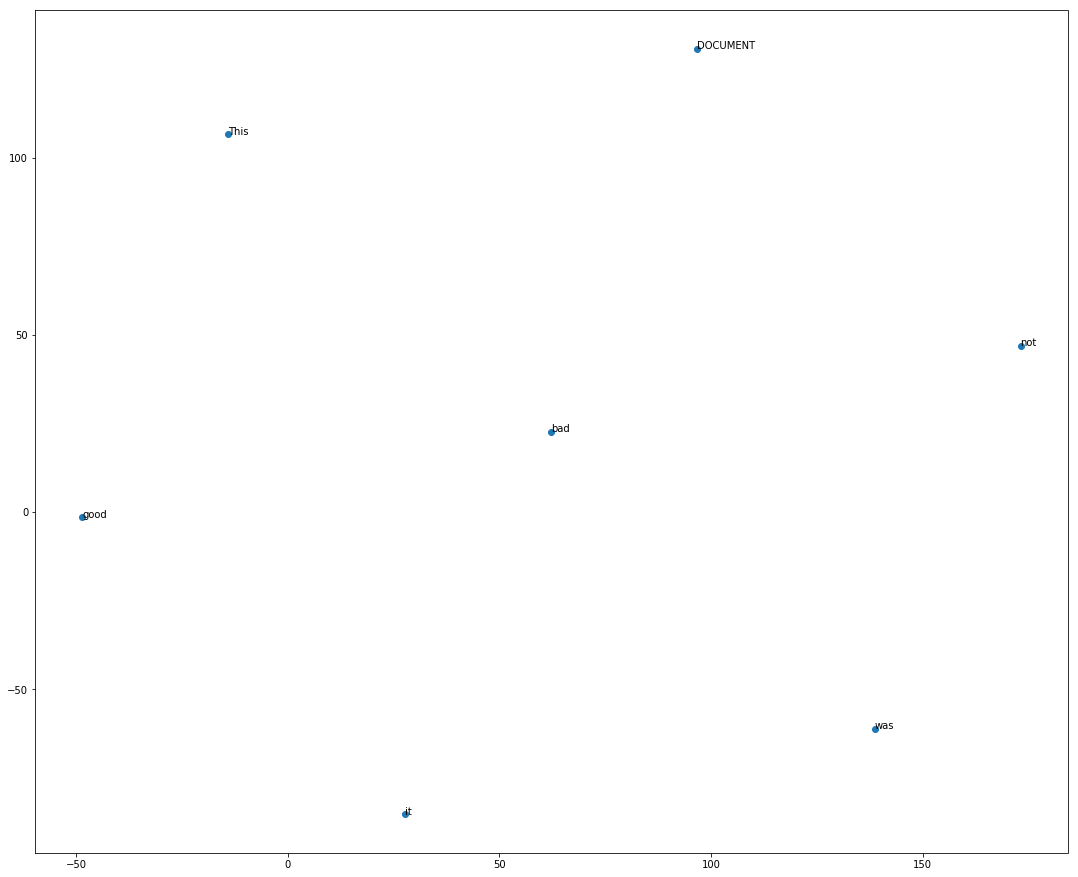

In [182]:
bad_review = ["This", "was", "not", "good", "it", "was", "bad"]
good_review = ["This", "was", "not", "bad", "it", "was", "good"]
plot_words_in_document(bad_review)
# plot_words_in_document(good_review)

In [168]:
# plot_words_in_document(bad_review)
# plot_words_in_document(good_review)

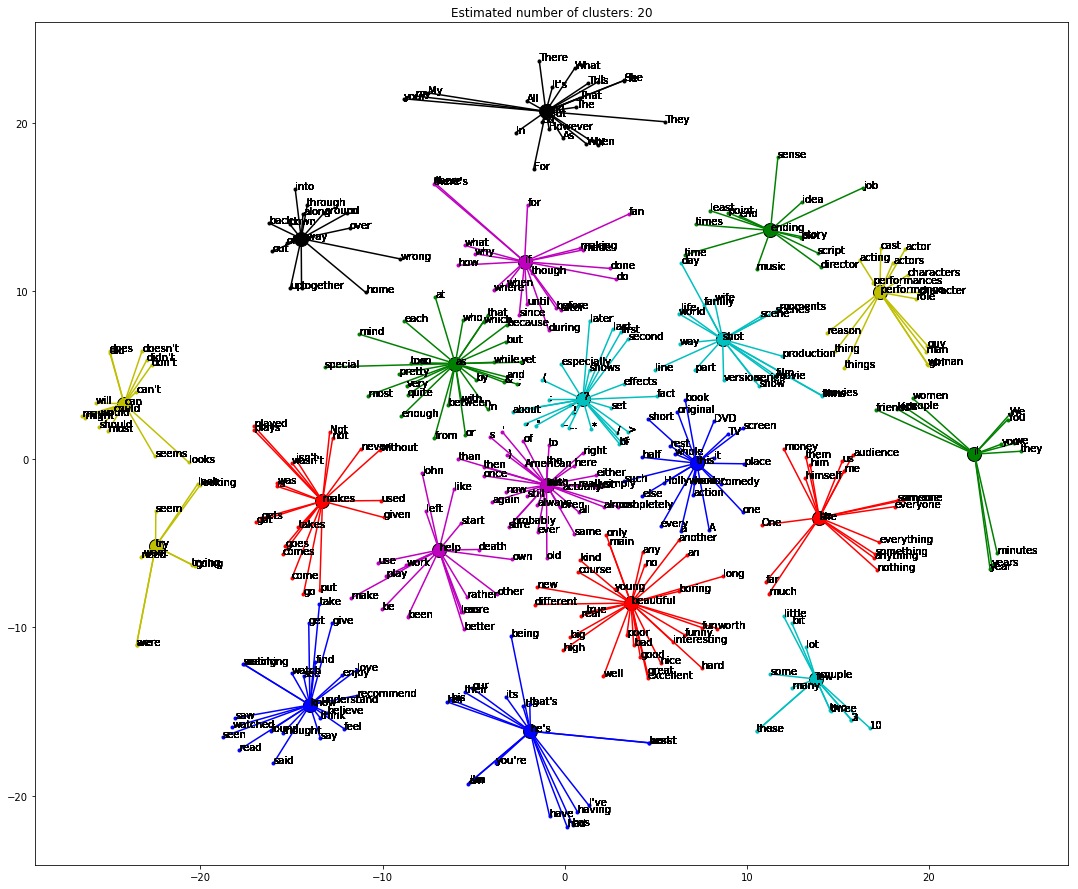

In [145]:
fig = plt.figure()
fig.set_size_inches(18.5, 15.5)
ax = fig.add_subplot("111")

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = reduced_vectors[cluster_centers_indices[k]]
    ax.plot(reduced_vectors[class_members, 0], reduced_vectors[class_members, 1], col + '.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in reduced_vectors[class_members]:
        ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
    for x, y, label in zip(xs, ys, doc2vec_model.wv.index2word[:400]):
        ax.annotate(label, (x, y))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()